**DATA IMPORT AND AUGMENTATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

In [ ]:
#Create new path to store augmented images
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
def load_data(path):
  train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
  train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

  test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
  test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

  return (train_x, train_y), (test_x,test_y)

In [ ]:
def augment_data(images, masks, save_path, augment=True):
  size=(512,512)

  #Now we loop over image and mask
  for idx, (x,y) in tqdm(enumerate(zip(images,masks)), total=len(images)):
    #extracting name of the image
    name = (x.split('/')[-1]).split(".")[0]

    #Reading the image and mask
    #for image we use cv2 and for the mask we use imageio

    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    if augment == True:
      aug = HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug = VerticalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented["image"]
      y2 = augmented["mask"]

      aug = Rotate(limit=45, p=1.0)
      augmented = aug(image=x, mask=y)
      x3 = augmented["image"]
      y3 = augmented["mask"]

      X = [x, x1, x2, x3]
      Y = [y, y1, y2, y3]

    else:
      X = [x]
      Y = [y]

    index = 0
    for i, m in zip(X,Y):
      i = cv2.resize(i, size)
      m = cv2.resize(m, size)

      tmp_image_name = f"{name}_{index}.png"
      tmp_mask_name = f"{name}_{index}.png"

      image_path = os.path.join(save_path, "image", tmp_image_name)
      mask_path = os.path.join(save_path, "mask", tmp_mask_name)  

      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, m)  

      index+=1


In [ ]:
if __name__ == "main":
  np.random.seed(42)

In [ ]:
##Load the data
data_path = "/content/drive/MyDrive/Retina Vessel Segmentation/DRIVE/"
(train_x, train_y), (test_x,test_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 20 - 20
Test: 20 - 20


In [ ]:
#Now we create directories to save our augmented data
create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

In [ ]:
#Data augmentation
augment_data(train_x,train_y,"new_data/train/",augment=True)

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


In [ ]:
augment_data(test_x,test_y,"new_data/test/",augment=False)

100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


**CREATING U-NET ARCHITECTURE**

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c,out_c,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c,out_c,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    return x


class encoder_block(nn.Module):
  def __init__(self, in_c,out_c):
    super().__init__()

    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x,p

class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    #Number of input channels will be outputchannles*2
    self.conv = conv_block(out_c+out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x
   


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        ##Encoder 
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        ##Bottleneck
        self.b = conv_block(512, 1024)  

        ##Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)


        ##Classifier 
        #To generate the final segmentation
        self.outputs = nn.Conv2d(64,1, kernel_size=1, padding=0)

    
    def forward(self, inputs):
        ##Encoder 
        #The output from the encoder layer acts as a skip connection for the decoder layer
        #s1 stands for skip connections
        #p1 stands for pooling output

        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        #Bottleneck
        b = self.b(p4)
        #print(s1.shape, s2.shape, s3.shape, s4.shape)
        #print(b.shape)

        ##Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        #Classifier
        outputs = self.outputs(d4)
        return outputs



if __name__ == "__main__":
  x = torch.randn((2,3,512,512))
  f = build_unet()
  y=f(x)
  print(y.shape)

torch.Size([2, 1, 512, 512])


**LOSS**

In [ ]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

**UTILS**

In [ ]:
import os
import time
import random
import numpy as np
import cv2
import torch

##Seeding the randomness
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

##Create a directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

##Calculate the time taken
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**TRAINING**

In [ ]:
import os
import time
from glob import glob

from torch.utils.data import DataLoader

In [ ]:
if __name__ == "__main__":
  #Seeding
  seeding(42)

  #Saving the checkpoints and other files
  create_dir("files")

  #load the dataset
  train_x = sorted(glob("/content/new_data/train/image/*"))
  train_y = sorted(glob("/content/new_data/train/mask/*"))

  valid_x = sorted(glob("/content/new_data/test/image/*"))
  valid_y = sorted(glob("/content/new_data/test/mask/*"))

  data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid:{len(test_x)}"
  print(data_str)

Dataset Size:
Train: 80 - Valid:20


In [ ]:
##Hyperparameters
H = 512
W = 512
size = (H,W)
batch_size = 4
num_epochs = 200
lr = 0.0001
checkpoint_path = "files/checkpoint.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


**DATASET AND LOADER**

In [ ]:
import os 
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

In [ ]:
class DriveDataset(Dataset):
  def __init__(self, images_path, masks_path):
    self.images_path = images_path
    self.masks_path = masks_path
    self.n_samples = len(images_path)

  def __getitem__(self, index):
    #Reading the image
    #Read the image in RGB format
    image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
    #Normalize the image by dividing with 255
    image = image/255.0
    #Transpose the image since it had channel last approach and for pytorch we need channel first
    image = np.transpose(image, (2,0,1))
    #Then we convert it into float32
    image = image.astype(np.float32)
    #Then we convert it to a torch tensor
    image = torch.from_numpy(image)

    #Reading the mask
    #We do not need transpose for mask
    mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=0)##(1,512,512)
    mask = mask.astype(np.float32)
    mask = torch.from_numpy(mask)

    return image, mask

  def __len__(self):
    return self.n_samples


In [ ]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers=2
)

In [ ]:
##Initialising the model
model = build_unet()
model = model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [ ]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred, type="All"):
    ##Ground truth
    y_true = y_true.cpu().detach().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    ##Prediction 
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    if type == "Jaccard":
      return score_jaccard
    elif type == "F1":
      return score_f1
    elif type == "Recall":
      return score_recall
    elif type == "Precision":
      return score_precision
    elif type == "Accuracy":
      return score_acc
    else:
      return [score_jaccard,score_f1,score_recall,score_precision,score_acc]

In [ ]:
##Specify the training function

def train(model, loader, optimizer, loss_fn, device):
  epoch_loss = 0.0
  model.train()
  for x,y in tqdm(loader):
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    #Optimizer put to zero grad
    optimizer.zero_grad()
    #Making a prediction
    y_pred = model(x)
    #Calculating loss
    loss = loss_fn(y_pred, y)
    #Backward step
    loss.backward()
    #Optimizer step
    optimizer.step()
    #Getting the loss for that epoch
    epoch_loss+=loss.item()
    

  #Calculating mean loss
  epoch_loss = epoch_loss/len(loader)

  return epoch_loss

In [ ]:
##Specify the evaluate function
def evaluate(model, loader, loss_fn, device):
  epoch_loss = 0.0
  model.eval()
  with torch.no_grad():
    for x,y in tqdm(loader):
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      y_pred = model(x)
      loss = loss_fn(y_pred,y)

      epoch_loss+=loss.item()

  #Calculating mean loss
  epoch_loss = epoch_loss/len(loader)
  return epoch_loss

In [ ]:
##Training the model
best_valid_loss = float("inf")
loss_store = []
val_loss_store = []
epoch_count = []

for epoch in range(num_epochs):
  start_time = time.time()
  train_loss = train(model, train_loader, optimizer, loss_fn, device)
  loss_store.append(train_loss)
  valid_loss = evaluate(model, valid_loader, loss_fn, device)
  val_loss_store.append(valid_loss)

  #Saving the model
  if valid_loss < best_valid_loss:
    data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:4f}"
    print(data_str)

    best_valid_loss = valid_loss
    torch.save(model.state_dict(), checkpoint_path)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  #Storing values
  epoch_count.append(epoch)


  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
  data_str += f'\tTrain Loss: {train_loss:.3f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
  print(data_str)

100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Valid loss improved from inf to 1.435321
Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 1.262
	 Val. Loss: 1.435



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Valid loss improved from 1.4353 to 1.315849
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 1.071
	 Val. Loss: 1.316



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Valid loss improved from 1.3158 to 1.056509
Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.995
	 Val. Loss: 1.057



100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Valid loss improved from 1.0565 to 0.950713
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.953
	 Val. Loss: 0.951



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Valid loss improved from 0.9507 to 0.895736
Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.922
	 Val. Loss: 0.896



100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Valid loss improved from 0.8957 to 0.878264
Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.896
	 Val. Loss: 0.878



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.8783 to 0.862619
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 0.871
	 Val. Loss: 0.863



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Valid loss improved from 0.8626 to 0.858846
Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.851
	 Val. Loss: 0.859



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.8588 to 0.834926
Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.829
	 Val. Loss: 0.835



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.8349 to 0.801364
Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.810
	 Val. Loss: 0.801



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.8014 to 0.785678
Epoch: 11 | Epoch Time: 0m 32s
	Train Loss: 0.792
	 Val. Loss: 0.786



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.7857 to 0.775131
Epoch: 12 | Epoch Time: 0m 32s
	Train Loss: 0.773
	 Val. Loss: 0.775



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.7751 to 0.763194
Epoch: 13 | Epoch Time: 0m 32s
	Train Loss: 0.758
	 Val. Loss: 0.763



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.7632 to 0.731083
Epoch: 14 | Epoch Time: 0m 32s
	Train Loss: 0.742
	 Val. Loss: 0.731



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.7311 to 0.728400
Epoch: 15 | Epoch Time: 0m 32s
	Train Loss: 0.725
	 Val. Loss: 0.728



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.7284 to 0.723570
Epoch: 16 | Epoch Time: 0m 33s
	Train Loss: 0.709
	 Val. Loss: 0.724



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.7236 to 0.701943
Epoch: 17 | Epoch Time: 0m 32s
	Train Loss: 0.696
	 Val. Loss: 0.702



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.7019 to 0.692593
Epoch: 18 | Epoch Time: 0m 32s
	Train Loss: 0.679
	 Val. Loss: 0.693



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.6926 to 0.664842
Epoch: 19 | Epoch Time: 0m 32s
	Train Loss: 0.661
	 Val. Loss: 0.665



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.6648 to 0.650376
Epoch: 20 | Epoch Time: 0m 32s
	Train Loss: 0.647
	 Val. Loss: 0.650



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.6504 to 0.636831
Epoch: 21 | Epoch Time: 0m 32s
	Train Loss: 0.634
	 Val. Loss: 0.637



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.6368 to 0.635775
Epoch: 22 | Epoch Time: 0m 33s
	Train Loss: 0.621
	 Val. Loss: 0.636



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.6358 to 0.617304
Epoch: 23 | Epoch Time: 0m 32s
	Train Loss: 0.606
	 Val. Loss: 0.617



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.6173 to 0.605651
Epoch: 24 | Epoch Time: 0m 32s
	Train Loss: 0.595
	 Val. Loss: 0.606



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.6057 to 0.587037
Epoch: 25 | Epoch Time: 0m 32s
	Train Loss: 0.580
	 Val. Loss: 0.587



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.5870 to 0.581903
Epoch: 26 | Epoch Time: 0m 32s
	Train Loss: 0.566
	 Val. Loss: 0.582



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Valid loss improved from 0.5819 to 0.575369
Epoch: 27 | Epoch Time: 0m 32s
	Train Loss: 0.554
	 Val. Loss: 0.575



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.5754 to 0.552581
Epoch: 28 | Epoch Time: 0m 32s
	Train Loss: 0.541
	 Val. Loss: 0.553



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 29 | Epoch Time: 0m 32s
	Train Loss: 0.526
	 Val. Loss: 0.561



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.5526 to 0.551882
Epoch: 30 | Epoch Time: 0m 32s
	Train Loss: 0.515
	 Val. Loss: 0.552



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.5519 to 0.549583
Epoch: 31 | Epoch Time: 0m 32s
	Train Loss: 0.501
	 Val. Loss: 0.550



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.5496 to 0.542039
Epoch: 32 | Epoch Time: 0m 32s
	Train Loss: 0.494
	 Val. Loss: 0.542



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.5420 to 0.530853
Epoch: 33 | Epoch Time: 0m 32s
	Train Loss: 0.480
	 Val. Loss: 0.531



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.5309 to 0.519408
Epoch: 34 | Epoch Time: 0m 32s
	Train Loss: 0.464
	 Val. Loss: 0.519



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.5194 to 0.517156
Epoch: 35 | Epoch Time: 0m 32s
	Train Loss: 0.450
	 Val. Loss: 0.517



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.5172 to 0.512453
Epoch: 36 | Epoch Time: 0m 32s
	Train Loss: 0.438
	 Val. Loss: 0.512



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.5125 to 0.502226
Epoch: 37 | Epoch Time: 0m 32s
	Train Loss: 0.427
	 Val. Loss: 0.502



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 38 | Epoch Time: 0m 32s
	Train Loss: 0.417
	 Val. Loss: 0.504



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.5022 to 0.495305
Epoch: 39 | Epoch Time: 0m 32s
	Train Loss: 0.407
	 Val. Loss: 0.495



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.4953 to 0.494790
Epoch: 40 | Epoch Time: 0m 32s
	Train Loss: 0.396
	 Val. Loss: 0.495



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.4948 to 0.484589
Epoch: 41 | Epoch Time: 0m 33s
	Train Loss: 0.386
	 Val. Loss: 0.485



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4846 to 0.477943
Epoch: 42 | Epoch Time: 0m 32s
	Train Loss: 0.376
	 Val. Loss: 0.478



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4779 to 0.473210
Epoch: 43 | Epoch Time: 0m 32s
	Train Loss: 0.366
	 Val. Loss: 0.473



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4732 to 0.471908
Epoch: 44 | Epoch Time: 0m 32s
	Train Loss: 0.361
	 Val. Loss: 0.472



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4719 to 0.467184
Epoch: 45 | Epoch Time: 0m 32s
	Train Loss: 0.352
	 Val. Loss: 0.467



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4672 to 0.459737
Epoch: 46 | Epoch Time: 0m 32s
	Train Loss: 0.346
	 Val. Loss: 0.460



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 47 | Epoch Time: 0m 32s
	Train Loss: 0.340
	 Val. Loss: 0.462



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Valid loss improved from 0.4597 to 0.458613
Epoch: 48 | Epoch Time: 0m 32s
	Train Loss: 0.334
	 Val. Loss: 0.459



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4586 to 0.448944
Epoch: 49 | Epoch Time: 0m 32s
	Train Loss: 0.326
	 Val. Loss: 0.449



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 50 | Epoch Time: 0m 32s
	Train Loss: 0.321
	 Val. Loss: 0.451



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.4489 to 0.445882
Epoch: 51 | Epoch Time: 0m 33s
	Train Loss: 0.314
	 Val. Loss: 0.446



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4459 to 0.438099
Epoch: 52 | Epoch Time: 0m 32s
	Train Loss: 0.308
	 Val. Loss: 0.438



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 53 | Epoch Time: 0m 32s
	Train Loss: 0.302
	 Val. Loss: 0.440



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4381 to 0.437776
Epoch: 54 | Epoch Time: 0m 32s
	Train Loss: 0.296
	 Val. Loss: 0.438



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4378 to 0.431204
Epoch: 55 | Epoch Time: 0m 32s
	Train Loss: 0.293
	 Val. Loss: 0.431



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 56 | Epoch Time: 0m 32s
	Train Loss: 0.290
	 Val. Loss: 0.433



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.4312 to 0.430629
Epoch: 57 | Epoch Time: 0m 33s
	Train Loss: 0.284
	 Val. Loss: 0.431



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4306 to 0.425475
Epoch: 58 | Epoch Time: 0m 32s
	Train Loss: 0.279
	 Val. Loss: 0.425



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4255 to 0.424702
Epoch: 59 | Epoch Time: 0m 32s
	Train Loss: 0.277
	 Val. Loss: 0.425



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 60 | Epoch Time: 0m 32s
	Train Loss: 0.271
	 Val. Loss: 0.426



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4247 to 0.421029
Epoch: 61 | Epoch Time: 0m 32s
	Train Loss: 0.267
	 Val. Loss: 0.421



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.4210 to 0.418578
Epoch: 62 | Epoch Time: 0m 32s
	Train Loss: 0.263
	 Val. Loss: 0.419



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.4186 to 0.416376
Epoch: 63 | Epoch Time: 0m 33s
	Train Loss: 0.260
	 Val. Loss: 0.416



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 64 | Epoch Time: 0m 32s
	Train Loss: 0.257
	 Val. Loss: 0.422



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.4164 to 0.413766
Epoch: 65 | Epoch Time: 0m 32s
	Train Loss: 0.254
	 Val. Loss: 0.414



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 66 | Epoch Time: 0m 32s
	Train Loss: 0.252
	 Val. Loss: 0.417



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4138 to 0.410298
Epoch: 67 | Epoch Time: 0m 32s
	Train Loss: 0.251
	 Val. Loss: 0.410



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 68 | Epoch Time: 0m 32s
	Train Loss: 0.246
	 Val. Loss: 0.413



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 69 | Epoch Time: 0m 32s
	Train Loss: 0.244
	 Val. Loss: 0.415



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.4103 to 0.408958
Epoch: 70 | Epoch Time: 0m 32s
	Train Loss: 0.240
	 Val. Loss: 0.409



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4090 to 0.404689
Epoch: 71 | Epoch Time: 0m 32s
	Train Loss: 0.237
	 Val. Loss: 0.405



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4047 to 0.402852
Epoch: 72 | Epoch Time: 0m 32s
	Train Loss: 0.235
	 Val. Loss: 0.403



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.4029 to 0.400479
Epoch: 73 | Epoch Time: 0m 32s
	Train Loss: 0.231
	 Val. Loss: 0.400



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 74 | Epoch Time: 0m 32s
	Train Loss: 0.230
	 Val. Loss: 0.402



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.4005 to 0.400263
Epoch: 75 | Epoch Time: 0m 32s
	Train Loss: 0.227
	 Val. Loss: 0.400



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 76 | Epoch Time: 0m 32s
	Train Loss: 0.226
	 Val. Loss: 0.401



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 77 | Epoch Time: 0m 32s
	Train Loss: 0.227
	 Val. Loss: 0.402



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 78 | Epoch Time: 0m 32s
	Train Loss: 0.226
	 Val. Loss: 0.401



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.4003 to 0.398925
Epoch: 79 | Epoch Time: 0m 32s
	Train Loss: 0.225
	 Val. Loss: 0.399



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.3989 to 0.396706
Epoch: 80 | Epoch Time: 0m 32s
	Train Loss: 0.222
	 Val. Loss: 0.397



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 81 | Epoch Time: 0m 32s
	Train Loss: 0.219
	 Val. Loss: 0.398



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 82 | Epoch Time: 0m 32s
	Train Loss: 0.216
	 Val. Loss: 0.400



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 83 | Epoch Time: 0m 32s
	Train Loss: 0.216
	 Val. Loss: 0.397



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 84 | Epoch Time: 0m 32s
	Train Loss: 0.214
	 Val. Loss: 0.399



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 85 | Epoch Time: 0m 32s
	Train Loss: 0.212
	 Val. Loss: 0.400



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.3967 to 0.392475
Epoch: 86 | Epoch Time: 0m 32s
	Train Loss: 0.208
	 Val. Loss: 0.392



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.3925 to 0.390401
Epoch: 87 | Epoch Time: 0m 32s
	Train Loss: 0.207
	 Val. Loss: 0.390



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.3904 to 0.390162
Epoch: 88 | Epoch Time: 0m 33s
	Train Loss: 0.206
	 Val. Loss: 0.390



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.3902 to 0.389635
Epoch: 89 | Epoch Time: 0m 32s
	Train Loss: 0.204
	 Val. Loss: 0.390



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 90 | Epoch Time: 0m 32s
	Train Loss: 0.203
	 Val. Loss: 0.391



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.3896 to 0.388954
Epoch: 91 | Epoch Time: 0m 32s
	Train Loss: 0.202
	 Val. Loss: 0.389



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 92 | Epoch Time: 0m 32s
	Train Loss: 0.200
	 Val. Loss: 0.390



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 93 | Epoch Time: 0m 32s
	Train Loss: 0.198
	 Val. Loss: 0.389



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 94 | Epoch Time: 0m 32s
	Train Loss: 0.198
	 Val. Loss: 0.389



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 95 | Epoch Time: 0m 32s
	Train Loss: 0.197
	 Val. Loss: 0.396



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 96 | Epoch Time: 0m 32s
	Train Loss: 0.196
	 Val. Loss: 0.393



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.3890 to 0.388389
Epoch: 97 | Epoch Time: 0m 32s
	Train Loss: 0.195
	 Val. Loss: 0.388



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 98 | Epoch Time: 0m 32s
	Train Loss: 0.195
	 Val. Loss: 0.391



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.3884 to 0.387064
Epoch: 99 | Epoch Time: 0m 32s
	Train Loss: 0.194
	 Val. Loss: 0.387



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 100 | Epoch Time: 0m 32s
	Train Loss: 0.193
	 Val. Loss: 0.388



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 101 | Epoch Time: 0m 32s
	Train Loss: 0.191
	 Val. Loss: 0.388



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 102 | Epoch Time: 0m 32s
	Train Loss: 0.190
	 Val. Loss: 0.388



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 103 | Epoch Time: 0m 32s
	Train Loss: 0.189
	 Val. Loss: 0.390



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.3871 to 0.386317
Epoch: 104 | Epoch Time: 0m 32s
	Train Loss: 0.189
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.3863 to 0.385723
Epoch: 105 | Epoch Time: 0m 32s
	Train Loss: 0.187
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 0.3857 to 0.382482
Epoch: 106 | Epoch Time: 0m 32s
	Train Loss: 0.186
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 107 | Epoch Time: 0m 32s
	Train Loss: 0.185
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.3825 to 0.382145
Epoch: 108 | Epoch Time: 0m 32s
	Train Loss: 0.184
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.3821 to 0.381967
Epoch: 109 | Epoch Time: 0m 32s
	Train Loss: 0.183
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 110 | Epoch Time: 0m 32s
	Train Loss: 0.183
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch: 111 | Epoch Time: 0m 32s
	Train Loss: 0.183
	 Val. Loss: 0.384



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 112 | Epoch Time: 0m 32s
	Train Loss: 0.182
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 113 | Epoch Time: 0m 33s
	Train Loss: 0.180
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 114 | Epoch Time: 0m 32s
	Train Loss: 0.180
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 115 | Epoch Time: 0m 32s
	Train Loss: 0.179
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 116 | Epoch Time: 0m 32s
	Train Loss: 0.179
	 Val. Loss: 0.384



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch: 117 | Epoch Time: 0m 32s
	Train Loss: 0.178
	 Val. Loss: 0.384



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 118 | Epoch Time: 0m 32s
	Train Loss: 0.177
	 Val. Loss: 0.385



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 119 | Epoch Time: 0m 32s
	Train Loss: 0.177
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch: 120 | Epoch Time: 0m 32s
	Train Loss: 0.177
	 Val. Loss: 0.387



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.3820 to 0.379629
Epoch: 121 | Epoch Time: 0m 32s
	Train Loss: 0.175
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 122 | Epoch Time: 0m 32s
	Train Loss: 0.175
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 123 | Epoch Time: 0m 32s
	Train Loss: 0.174
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 124 | Epoch Time: 0m 32s
	Train Loss: 0.174
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch: 125 | Epoch Time: 0m 32s
	Train Loss: 0.173
	 Val. Loss: 0.387



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 126 | Epoch Time: 0m 32s
	Train Loss: 0.173
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch: 127 | Epoch Time: 0m 32s
	Train Loss: 0.173
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 128 | Epoch Time: 0m 32s
	Train Loss: 0.173
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 129 | Epoch Time: 0m 32s
	Train Loss: 0.172
	 Val. Loss: 0.385



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 130 | Epoch Time: 0m 32s
	Train Loss: 0.171
	 Val. Loss: 0.385



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 131 | Epoch Time: 0m 32s
	Train Loss: 0.170
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 132 | Epoch Time: 0m 32s
	Train Loss: 0.170
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Valid loss improved from 0.3796 to 0.377747
Epoch: 133 | Epoch Time: 0m 32s
	Train Loss: 0.169
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 134 | Epoch Time: 0m 32s
	Train Loss: 0.169
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 135 | Epoch Time: 0m 32s
	Train Loss: 0.168
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 136 | Epoch Time: 0m 32s
	Train Loss: 0.167
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 137 | Epoch Time: 0m 32s
	Train Loss: 0.167
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 138 | Epoch Time: 0m 32s
	Train Loss: 0.167
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 139 | Epoch Time: 0m 32s
	Train Loss: 0.166
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 140 | Epoch Time: 0m 32s
	Train Loss: 0.166
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 141 | Epoch Time: 0m 32s
	Train Loss: 0.166
	 Val. Loss: 0.386



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 142 | Epoch Time: 0m 32s
	Train Loss: 0.166
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 143 | Epoch Time: 0m 32s
	Train Loss: 0.166
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 144 | Epoch Time: 0m 32s
	Train Loss: 0.165
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 145 | Epoch Time: 0m 32s
	Train Loss: 0.165
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 146 | Epoch Time: 0m 32s
	Train Loss: 0.164
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 147 | Epoch Time: 0m 32s
	Train Loss: 0.163
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 148 | Epoch Time: 0m 32s
	Train Loss: 0.163
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 149 | Epoch Time: 0m 32s
	Train Loss: 0.163
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 150 | Epoch Time: 0m 32s
	Train Loss: 0.162
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 151 | Epoch Time: 0m 32s
	Train Loss: 0.162
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 152 | Epoch Time: 0m 32s
	Train Loss: 0.162
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 153 | Epoch Time: 0m 32s
	Train Loss: 0.162
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 154 | Epoch Time: 0m 32s
	Train Loss: 0.162
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 155 | Epoch Time: 0m 32s
	Train Loss: 0.162
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 156 | Epoch Time: 0m 32s
	Train Loss: 0.161
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 157 | Epoch Time: 0m 32s
	Train Loss: 0.161
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Valid loss improved from 0.3777 to 0.376325
Epoch: 158 | Epoch Time: 0m 32s
	Train Loss: 0.161
	 Val. Loss: 0.376



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 159 | Epoch Time: 0m 32s
	Train Loss: 0.160
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 160 | Epoch Time: 0m 32s
	Train Loss: 0.159
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 161 | Epoch Time: 0m 32s
	Train Loss: 0.159
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 162 | Epoch Time: 0m 32s
	Train Loss: 0.159
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 163 | Epoch Time: 0m 32s
	Train Loss: 0.159
	 Val. Loss: 0.377



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 164 | Epoch Time: 0m 32s
	Train Loss: 0.159
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 165 | Epoch Time: 0m 32s
	Train Loss: 0.159
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 166 | Epoch Time: 0m 32s
	Train Loss: 0.158
	 Val. Loss: 0.377



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 167 | Epoch Time: 0m 32s
	Train Loss: 0.158
	 Val. Loss: 0.385



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 168 | Epoch Time: 0m 32s
	Train Loss: 0.158
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 169 | Epoch Time: 0m 32s
	Train Loss: 0.158
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 170 | Epoch Time: 0m 32s
	Train Loss: 0.158
	 Val. Loss: 0.377



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 171 | Epoch Time: 0m 32s
	Train Loss: 0.157
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 172 | Epoch Time: 0m 32s
	Train Loss: 0.156
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 173 | Epoch Time: 0m 32s
	Train Loss: 0.156
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 174 | Epoch Time: 0m 32s
	Train Loss: 0.156
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch: 175 | Epoch Time: 0m 32s
	Train Loss: 0.156
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 176 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch: 177 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 178 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.377



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 179 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 0.3763 to 0.376066
Epoch: 180 | Epoch Time: 0m 33s
	Train Loss: 0.154
	 Val. Loss: 0.376



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 181 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 182 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.384



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 183 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 184 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 185 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 186 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.378



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 187 | Epoch Time: 0m 32s
	Train Loss: 0.155
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 188 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.384



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 189 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 190 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 191 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 192 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.382



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 193 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.383



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 194 | Epoch Time: 0m 32s
	Train Loss: 0.154
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch: 195 | Epoch Time: 0m 32s
	Train Loss: 0.153
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 196 | Epoch Time: 0m 32s
	Train Loss: 0.153
	 Val. Loss: 0.379



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 197 | Epoch Time: 0m 32s
	Train Loss: 0.153
	 Val. Loss: 0.381



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch: 198 | Epoch Time: 0m 32s
	Train Loss: 0.152
	 Val. Loss: 0.377



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch: 199 | Epoch Time: 0m 32s
	Train Loss: 0.152
	 Val. Loss: 0.380



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

Epoch: 200 | Epoch Time: 0m 32s
	Train Loss: 0.152
	 Val. Loss: 0.380



**CHECKING ACCURACY**

In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":

    jaccard_store = []
    precision_store = []
    f1_store = []
    recall_store = []
    acc_store = []
    test_epoch_count = []
    ##Seeding 
    seeding(42)

    ##Folders
    create_dir("results")

    ##Load dataset 
    test_x = sorted(glob("/content/new_data/test/image/*"))
    test_y = sorted(glob("/content/new_data/test/mask/*"))

    ##Hyperparameters 
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    ##Load the checkpoint 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        ##Extract the name 
        name = x.split("/")[-1].split(".")[0]

        ##Reading image 
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        ##Reading mask 
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            ##Prediction and Calculating FPS 
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y, type="All")
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        ##Saving masks 
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

        #Calculate the metrics for each batch
        jaccard = score[0]
        precision = score[3]
        recall= score[2]
        f1 = score[1]
        acc = score[4]

        #Store in the list
        jaccard_store.append(jaccard)
        precision_store.append(precision)
        f1_store.append(f1)
        recall_store.append(f1)
        acc_store.append(f1)
        test_epoch_count.append(i)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

Jaccard: 0.6597 - F1: 0.7947 - Recall: 0.7749 - Precision: 0.8207 - Acc: 0.9653
FPS:  137.9385372800058


In [ ]:
jaccard_store

[0.6752363344612272,
 0.707980827998842,
 0.617250017396145,
 0.68215293298648,
 0.6495892621387708,
 0.6354588092084065,
 0.6588356214668527,
 0.6296598957117285,
 0.6274268235693955,
 0.658498023715415,
 0.6503804850295143,
 0.6675734905161339,
 0.6621565792191696,
 0.6661284742244262,
 0.6581634815034535,
 0.6756073430801363,
 0.6402145401871354,
 0.6618469250048198,
 0.7121918472382799,
 0.6570498474059003]

In [ ]:
recall_store

[0.8061385973679827,
 0.8290266686756064,
 0.7633328313577007,
 0.8110474613926946,
 0.7875769769458216,
 0.7771015761821366,
 0.7943350298738658,
 0.7727500656653692,
 0.7710660958546518,
 0.794089609151573,
 0.7881582349392399,
 0.8006525581184575,
 0.7967439259305287,
 0.7996123762718903,
 0.7938463111088395,
 0.806402939053992,
 0.7806473171663165,
 0.7965197215777263,
 0.8319065978348472,
 0.7930357055154461]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_items(x,y,xlabel,ylabel,label,title):
  plt.plot(x, np.array(y), label=label)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.legend()

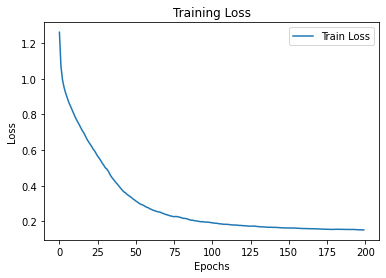

In [ ]:
plot_items(np.array(epoch_count), np.array(loss_store),"Epochs","Loss","Train Loss","Training Loss")

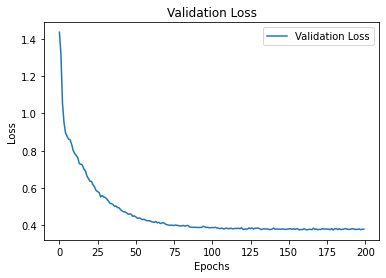

In [ ]:
plot_items(np.array(epoch_count), np.array(val_loss_store),"Epochs","Loss","Validation Loss","Validation Loss")

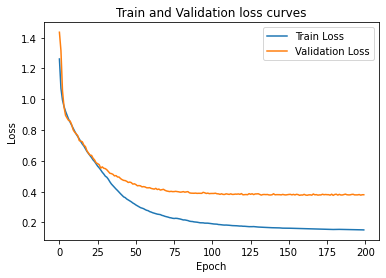

In [ ]:
plt.plot(epoch_count, np.array(loss_store), label="Train Loss")
plt.plot(epoch_count, np.array(val_loss_store), label = "Validation Loss")
plt.title("Train and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
np.array(acc_store).shape

(20,)

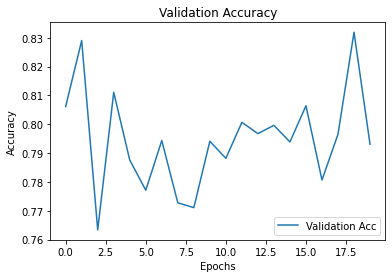

In [ ]:
plot_items(np.array(test_epoch_count), np.array(acc_store),"Epochs","Accuracy","Validation Acc","Validation Accuracy")

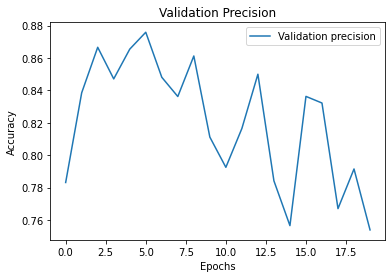

In [ ]:
plot_items(np.array(test_epoch_count), np.array(precision_store),"Epochs","Accuracy","Validation precision","Validation Precision")

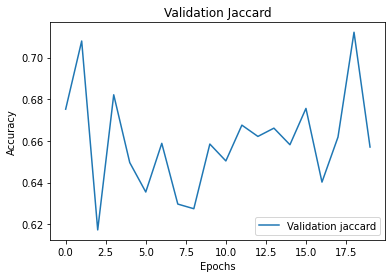

In [ ]:
plot_items(np.array(test_epoch_count), np.array(jaccard_store),"Epochs","Accuracy","Validation jaccard","Validation Jaccard")

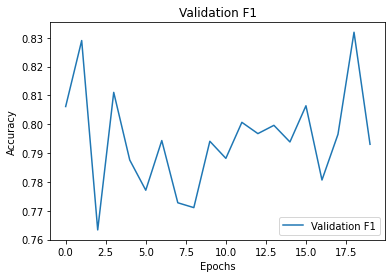

In [ ]:
plot_items(np.array(test_epoch_count), np.array(f1_store),"Epochs","Accuracy","Validation F1","Validation F1")

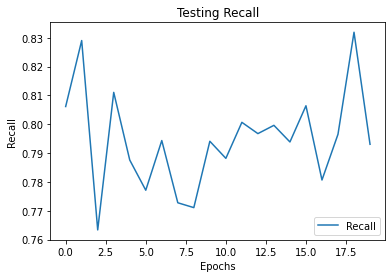

In [ ]:
plot_items(np.array(test_epoch_count), np.array(recall_store),"Epochs","Recall","Recall","Testing Recall")

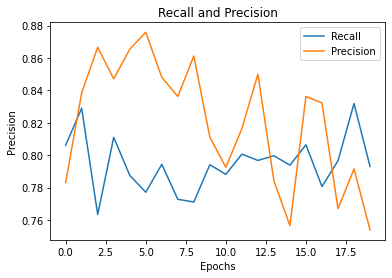

In [ ]:
plot_items(np.array(test_epoch_count), np.array(recall_store),"Epochs","Recall","Recall","Recall and Precision")
plot_items(np.array(test_epoch_count), np.array(precision_store),"Epochs","Precision","Precision","Recall and Precision")

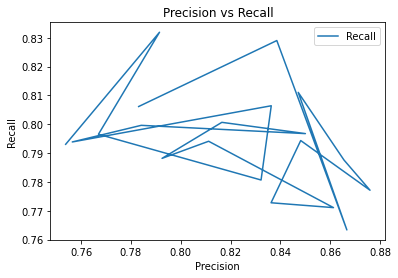

In [ ]:
plot_items(np.array(precision_store), np.array(recall_store),"Precision","Recall","Recall","Precision vs Recall")

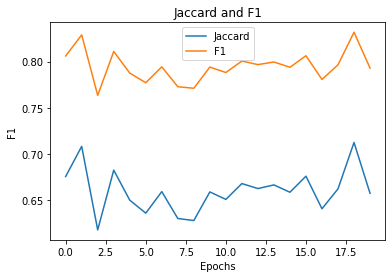

In [ ]:
plot_items(np.array(test_epoch_count), np.array(jaccard_store),"Epochs","Jaccard","Jaccard","Jaccard and F1")
plot_items(np.array(test_epoch_count), np.array(f1_store),"Epochs","F1","F1","Jaccard and F1")

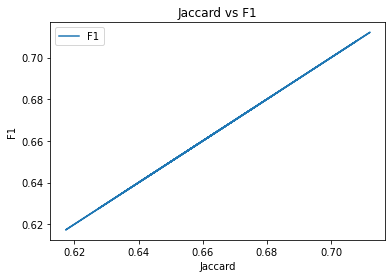

In [ ]:
plot_items(np.array(jaccard_store), np.array(jaccard_store),"Jaccard","F1","F1","Jaccard vs F1")

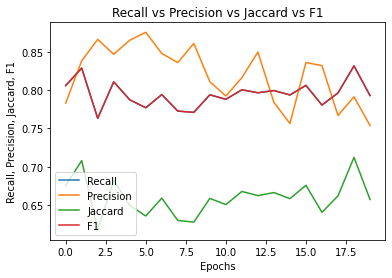

In [ ]:
plot_items(np.array(test_epoch_count), np.array(recall_store),"Epochs","Recall, Precision, Jaccard, F1","Recall","Recall vs Precision vs Jaccard vs F1")
plot_items(np.array(test_epoch_count), np.array(precision_store),"Epochs","Recall, Precision, Jaccard, F1","Precision","Recall vs Precision vs Jaccard vs F1")
plot_items(np.array(test_epoch_count), np.array(jaccard_store),"Epochs","Recall, Precision, Jaccard, F1","Jaccard","Recall vs Precision vs Jaccard vs F1")
plot_items(np.array(test_epoch_count), np.array(f1_store),"Epochs","Recall, Precision, Jaccard, F1","F1","Recall vs Precision vs Jaccard vs F1")